---

<h1><b><center>Analysis of EV Charging Data to Predict Optimal Charging Duration</b></h1>
<h2><center>Group 48</h2>

---

---

<h1><center>Performance Metric</h1>

---

Since we are working with a regression problem, we will use R2 as our performance metric. For our logistic regression section, we will use accuracy. 

---

<h1><center>Data Pre-Processing</h1>

---

In [1]:
# Libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
import time
tot_start = time.time()

<h3><center>Clean and Inspect the Data</h3>

In [3]:
# Set a random seed to maintain consistent results
rand_seed = 873465

In [55]:
# Import data
df = pd.read_csv('data\ev_battery_charging_data.csv')

In [5]:
# Drop rows with any NaN values
df_clean = df.dropna()

# Shape after cleaning
print("After removing rows with NaN:")
print(f"Rows: {df_clean.shape[0]}, Columns: {df_clean.shape[1]}")

After removing rows with NaN:
Rows: 1000, Columns: 13


In [6]:
# Drop inputs calculated from the column we are predicting
drop_cols = ['Degradation Rate (%)', 'Efficiency (%)', 'Optimal Charging Duration Class']
df_clean = df_clean.drop(columns=drop_cols)

In [7]:
# List the categorical columns and numerical columns for later pre-processing steps
cat_col = ['Charging Mode', 'Battery Type', 'EV Model']
num_col = ['SOC (%)', 'Voltage (V)', 'Current (A)', 'Battery Temp (°C)', 'Ambient Temp (°C)', 'Charging Cycles']
target = 'Charging Duration (min)'

In [8]:
# Move the column we are predicting to the end to maintain consistent format
df_clean[target] = df_clean.pop(target)

In [9]:
# Inspect the data
df_clean.head()

,SOC (%),Voltage (V),Current (A),Battery Temp (°C),Ambient Temp (°C),Charging Mode,Battery Type,Charging Cycles,EV Model,Charging Duration (min)
0,43.708611,3.629593,33.553512,33.454060,26.439918,Fast,Li-ion,112,Model B,59.363552
1,95.564288,3.879331,32.228092,35.933628,31.108647,Fast,LiFePO4,398,Model A,67.343566
2,75.879455,4.111062,91.562912,25.009358,30.203219,Slow,LiFePO4,175,Model A,105.454739
3,63.879264,4.012557,32.459158,32.497482,18.077998,Fast,LiFePO4,150,Model B,54.000439
4,24.041678,4.064593,34.475475,31.434920,17.984989,Fast,Li-ion,886,Model C,106.964968


In [10]:
df_clean.describe(include='all')

,SOC (%),Voltage (V),Current (A),Battery Temp (°C),Ambient Temp (°C),Charging Mode,Battery Type,Charging Cycles,EV Model,Charging Duration (min)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000,1000,1000.000000,1000,1000.000000
unique,NaN,NaN,NaN,NaN,NaN,3,2,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,Slow,LiFePO4,NaN,Model C,NaN
freq,NaN,NaN,NaN,NaN,NaN,341,503,NaN,343,NaN
mean,54.123090,3.854912,55.216515,29.807501,24.882106,NaN,NaN,556.560000,NaN,69.846449
std,26.292363,0.204533,26.160678,5.729787,5.736199,NaN,NaN,263.763052,NaN,28.919481
min,10.416882,3.502253,10.001047,20.013068,15.000614,NaN,NaN,101.000000,NaN,20.618382
25%,31.237594,3.668752,33.521588,24.838015,19.899480,NaN,NaN,317.750000,NaN,44.938000
50%,54.712664,3.863114,55.055253,29.685586,24.891962,NaN,NaN,571.000000,NaN,69.040282
75%,76.988763,4.032326,78.319317,34.750816,29.799869,NaN,NaN,786.000000,NaN,93.985178


<h3><center>Create Train, Validate, and Test Datasets</h3>

In [11]:
# Split the data into train, test, and validate
from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=target)
y = df_clean[target]

# Test data is 20% of total
Xtrain_valid, Xtest, ytrain_valid, ytest = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

# Train data is 70% of total and validate data is 10% of total
Xtrain, Xvalid, ytrain, yvalid = train_test_split(Xtrain_valid, ytrain_valid, test_size=0.125, random_state=rand_seed)

<h3><center>Scale Numerical Data and One-Hot Encode Categorical Data</h3>

In [12]:
# Preprocessor for numerical columns
num_transformer = Pipeline(
    steps=[("scaler", StandardScaler())])

# Preprocessor for categorical columns
cat_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(drop='first'))])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_col),
        ('cat', cat_transformer, cat_col)])

In [13]:
# Fit the preprocessor with the training data and apply to the training, validation, and testing data
Xtrain_norm = preprocessor.fit_transform(Xtrain)
Xvalid_norm = preprocessor.transform(Xvalid)
Xtest_norm = preprocessor.transform(Xtest)

# Convert to data frames for the neural network models
feature_names_x = preprocessor.get_feature_names_out()

Xtrain_norm_df = pd.DataFrame(Xtrain_norm, columns=feature_names_x, index=Xtrain.index)
Xvalid_norm_df = pd.DataFrame(Xvalid_norm, columns=feature_names_x, index=Xvalid.index)
Xtest_norm_df = pd.DataFrame(Xtest_norm, columns=feature_names_x, index=Xtest.index)

ytrain_df = pd.DataFrame(ytrain)
yvalid_df = pd.DataFrame(yvalid)
ytest_df = pd.DataFrame(ytest)

---

<h1><center>Train and Evaluate Models</h1>

---

In [14]:
# Make a dictionary to store the best results of each family of models
results = []

---

<h1><center>Linear Regression Models</h1>

---

In [15]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

<h3><center>Linear Regression with Feature Selection</h3>

In [16]:
# Linear regression with feature selection
# There are 11 features in the cleaned data, so 11 models are made
# Scikit-learn's recursive feature elimination (RFE) is used
linreg_models = []

for i in range(1, Xtrain_norm.shape[1]+1):
    linreg_pipe = Pipeline([('feat_selection', RFE(estimator=LinearRegression(), n_features_to_select=i)),
                            ('linreg', LinearRegression())])
    linreg_pipe.fit(Xtrain_norm, ytrain)

    features = feature_names_x[linreg_pipe.named_steps['feat_selection'].support_]
    
    train_r2 = linreg_pipe.score(Xtrain_norm, ytrain)
    val_r2 = np.mean(cross_val_score(linreg_pipe, Xtrain_norm, ytrain, scoring='r2', cv=8))
    
    linreg_models.append({'Model Name': 'Linear Regression',
                          'Model': linreg_pipe,
                          'Parameters': {'Number of Features': i, 'Feature Names': features},
                          'Train R2': train_r2,
                          'Validate R2': val_r2})

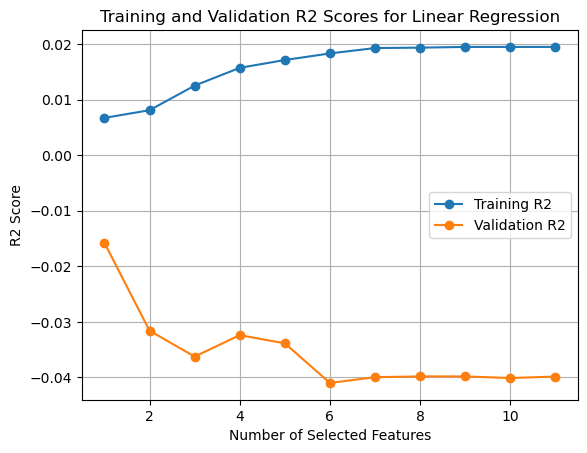

In [17]:
# Plot of training R2 and validation R2 vs number of features for linear regression with feature selection
num_features = [temp['Parameters']['Number of Features'] for temp in linreg_models]
train_r2s = [temp['Train R2'] for temp in linreg_models]
val_r2s = [temp['Validate R2'] for temp in linreg_models]

plt.plot(num_features, train_r2s, label='Training R2', marker='o')
plt.plot(num_features, val_r2s, label='Validation R2', marker='o')
plt.title('Training and Validation R2 Scores for Linear Regression')
plt.xlabel('Number of Selected Features')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Add the best model to the main results dictionary
idx = np.argmax(val_r2s)
results.append(linreg_models[idx])
print('The best model for linear regression with feature selection')
print(f'Validation R2 score: {val_r2s[idx]:.3}')
print(f'Number of Features: {num_features[idx]}')
features = [temp['Parameters']['Feature Names'] for temp in linreg_models]
print(f'Name of the Feature(s): {', '.join(features[idx])}')

The best model for linear regression with feature selection:
Validation R2 score: -0.0158
Number of Features: 1
Name of the Feature(s): cat__EV Model_Model B


<h3><center>Lasso Regression</h3>

In [19]:
# Lasso regression
# The alpha range was found by testing a number of different ranges
alphas = np.logspace(-2, 1, 10)
lasso_models = []

for alpha in alphas:
    lasso_pipe = Pipeline([('lasso', Lasso(alpha=alpha, max_iter=10000))])
    lasso_pipe.fit(Xtrain_norm, ytrain)

    train_r2 = lasso_pipe.score(Xtrain_norm, ytrain)
    val_r2 = np.mean(cross_val_score(lasso_pipe, Xtrain_norm, ytrain, scoring='r2', cv=8))
    
    lasso_models.append({'Model Name': 'Linear Regression',
                         'Model': lasso_pipe,
                         'Parameters': {'Alpha': alpha},
                         'Train R2': train_r2,
                         'Validate R2': val_r2})

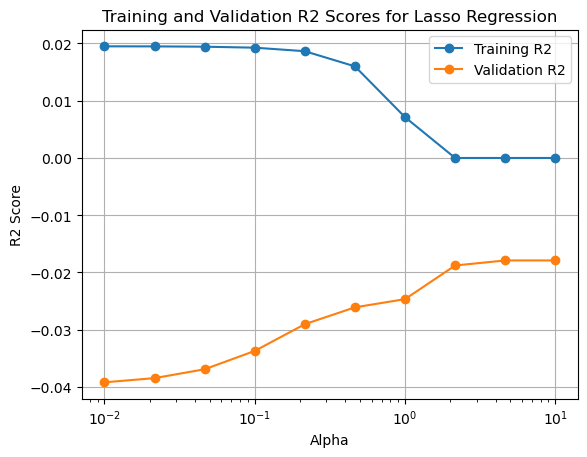

In [20]:
# Plot of training R2 and validation R2 vs number of features for linear regression with feature selection
alpha = [temp['Parameters']['Alpha'] for temp in lasso_models]
train_r2s = [temp['Train R2'] for temp in lasso_models]
val_r2s = [temp['Validate R2'] for temp in lasso_models]

plt.semilogx(alpha, train_r2s, label='Training R2', marker='o')
plt.semilogx(alpha, val_r2s, label='Validation R2', marker='o')
plt.title('Training and Validation R2 Scores for Lasso Regression')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Add the best model to the main results dictionary
idx = np.argmax(val_r2s)
results.append(lasso_models[idx])
print('The best model for lasso regression')
print(f'Validation R2 score: {val_r2s[idx]:.3}')
print(f'Alpha: {alpha[idx]:.3}')

The best model for lasso regression
Validation R2 score: -0.0179
Alpha: 4.64


---

<h1><center>Logistic Regression Comparison</h1>

---

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [23]:
# Switch the target column from numerical to categorical
# To maintain consistant training, validation, and testing datasets, the target column is split using pd.cut instead of using the orignal feature
ytrain_log = pd.cut(ytrain, bins=[0, 40, 80, np.inf], labels=[0, 1, 2,]).astype(int)

In [24]:
# Standard logistic regression model
# Before running models, note that a random guess would result in about 33% accuracy for 3 classes
# The validation accuracy should be much greater than 33% for a good model
logreg_pipe = Pipeline([
    ('logreg', LogisticRegression(max_iter=10000)) # Increased max_iter to ensure convergence
])

# Fit the model
logreg_pipe.fit(Xtrain_norm, ytrain_log)

# Evaluate
# For classification, we use accuracy (percentage of correct guesses)
train_score = logreg_pipe.score(Xtrain_norm, ytrain_log)
val_score = np.mean(cross_val_score(logreg_pipe, Xtrain_norm, ytrain_log, cv=8))

print(f"Standard Logistic Regression - Train: {train_score:.2%} | Validation: {val_score:.2%}")

Standard Logistic Regression - Train: 45.00% | Validation: 39.42%


In [25]:
# Balanced Logistic Regression
logreg_balanced = Pipeline([
    ('logreg', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

logreg_balanced.fit(Xtrain_norm, ytrain_log)

bal_train_score = logreg_balanced.score(Xtrain_norm, ytrain_log)
bal_val_score = np.mean(cross_val_score(logreg_balanced, Xtrain_norm, ytrain_log, cv=8))

print(f"Balanced Logistic Regression - Train: {bal_train_score:.2%} | Validation: {bal_val_score:.2%}")

Balanced Logistic Regression - Train: 38.57% | Validation: 32.43%


In [26]:
# Polynomial Logistic Regression (Degrees 2-5)
print("Testing Polynomial Degrees (2-5)...")
degrees_to_test = sorted({2, 3, 4, 5})

for d in degrees_to_test:
    poly_log_pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=d)),
        ('logreg', LogisticRegression(max_iter=2000))
    ])
    
    try:
        poly_log_pipe.fit(Xtrain_norm, ytrain_log)
        
        poly_train_score = poly_log_pipe.score(Xtrain_norm, ytrain_log)
        poly_val_score = np.mean(cross_val_score(poly_log_pipe, Xtrain_norm, ytrain_log, cv=8))
        
        print(f"    Degree {d} - Train: {poly_train_score:.2%} | Validation: {poly_val_score:.2%}")
        
    except Exception as e:
        print(f"   Degree {d} Failed: {e}")

Testing Polynomial Degrees (2-5)...
    Degree 2 - Train: 50.57% | Validation: 36.42%
    Degree 3 - Train: 83.71% | Validation: 37.56%
    Degree 4 - Train: 100.00% | Validation: 39.69%
    Degree 5 - Train: 100.00% | Validation: 39.55%


---

<h1><center>Neural Networks

---

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import regularizers
from itertools import product

Plan:<br>
1. Build a basic NN to get results<br>
    a. Build pipeline<br>
    b. Build NN model<br>
    c. Compile NN w/ pipeline<br>
    d. Calculate R2 score and compare with linreg<br>
2. Build function to build pipelines

In [28]:
# Build an MLP

ki = GlorotUniform(seed=2434)

model_mlp = Sequential([
    Dense(64, input_shape=(Xtrain_norm_df.shape[1],), activation='relu', kernel_initializer=ki),
    Dense(32, activation='relu', kernel_initializer=ki),
    Dense(16, activation='relu', kernel_initializer=ki),
    Dense(1, kernel_initializer=ki)
])

model_mlp.compile( optimizer="rmsprop", loss="mse", metrics=["r2_score"] )

C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# Train the MLP

history_mlp = model_mlp.fit(x=Xtrain_norm_df, y=ytrain_df, epochs=50, validation_data=(Xvalid_norm_df,yvalid_df))

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5557.3193 - r2_score: -5.7910 - val_loss: 5578.4443 - val_r2_score: -6.3448
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4991.7065 - r2_score: -5.0998 - val_loss: 4858.1270 - val_r2_score: -5.3964
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4075.2661 - r2_score: -3.9799 - val_loss: 3733.7507 - val_r2_score: -3.9160
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2828.8574 - r2_score: -2.4568 - val_loss: 2397.8022 - val_r2_score: -2.1570
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1691.7488 - r2_score: -1.0673 - val_loss: 1438.3275 - val_r2_score: -0.8938
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1128.1917 - r2_score: -0.3786 - val_loss: 1114.2700 - val_r2_score: -0.4671
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1014.7457 - r2_score: -0.2400 - val_loss: 1074.9673 - val_r2_score: -0.4153
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 982

In [30]:
mlp_perf = r2_score(ytrain_df, model_mlp.predict(Xtrain_norm_df))
mlp_perf_valid = r2_score(yvalid_df, model_mlp.predict(Xvalid_norm_df))
print(mlp_perf)
print(mlp_perf_valid)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
0.06058335304260254
-0.193914532661438


In [31]:
def build_model(num_layers, lr, x_data, last_reg_layer):

    num_units = np.zeros(num_layers, dtype=int)
    num_units[-1] = 1
    if num_layers > 1:
        for i in range(num_layers-1):
            num_units[i] = 2**(num_layers+1-i)

    layers = []
    ki = GlorotUniform(seed=2434)
    layers.append(Dense(num_units[0], input_shape=(x_data.shape[1],), activation='relu', kernel_initializer=ki))
    for i in range(1, num_layers-1):
        layers.append(Dense(num_units[i], activation='relu', kernel_initializer=ki))
    layers.append(Dense(1, kernel_initializer=ki, kernel_regularizer=last_reg_layer))


    model = Sequential(layers)

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

    model.compile( optimizer=optimizer, loss="mse", metrics=["r2_score"] )

    return model

In [32]:
param_grid = {
    'num_layers': [2, 3, 4, 5],
    'lr': [1e-3, 1e-2, 1e-1],
    'last_reg_layer': [None, regularizers.l1(1e-2),
                       regularizers.l1(1e-1),
                       regularizers.l2(1e-2), regularizers.l2(1e-1)],
    'epochs': [10, 25, 50]
}


In [33]:
all_combos = list(product(
    param_grid['num_layers'],
    param_grid['lr'],
    param_grid['last_reg_layer'],
    param_grid['epochs']   
))

In [34]:
def reg_to_str(reg):
    if reg is None:
        return "None"
    elif hasattr(reg, 'l1'):
        return f"L1({reg.l1:.3f})"   # rounds to 3 decimals
    elif hasattr(reg, 'l2'):
        return f"L2({reg.l2:.3f})"
    else:
        return str(reg)


In [35]:
results = []

for num_layers, lr, last_reg_layer, epochs in all_combos:

    model = build_model(num_layers, lr, Xtrain_norm_df, last_reg_layer)

    history = model.fit(
        x = Xtrain_norm_df,
        y = ytrain_df,
        epochs=epochs,
        validation_data = (Xvalid_norm_df, yvalid_df),
        verbose=0
    )

    y_hat_valid = model.predict(Xvalid_norm_df)
    perf_valid = r2_score(yvalid_df, y_hat_valid)

    y_hat_train = model.predict(Xtrain_norm_df)
    perf_train = r2_score(ytrain_df, y_hat_train)

    results.append({
    'num_layers': num_layers,
    'lr': lr,
    'last_reg_layer': reg_to_str(last_reg_layer),
    'epochs': epochs,
    'r2_train': perf_train,
    'r2_valid': perf_valid,
    'model': model,
    })

results_df = pd.DataFrame(results)

print(results_df.head())


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
   num_layers     lr last_reg_layer  epochs  r2_train  r2_valid  \
0           2  0.001           None      10 -5.781790 -6.653950   
1           2  0.001           None      25 -5.118966 -5.935813   
2           2  0.001           None      50 -3.491271 -4.117085   
3           2  0.001      L1(0.010)      10 -5.780286 -6.651867   
4           2  0.001      L1(0.010)      25 -5.118563 -5.938342   

                                        model  
0  <Sequential name=sequential_1, built=True>  
1  <Sequential name=sequential_2, built=True>  
2  <Sequential name=sequential_3, built=True>  
3  <Sequential name=sequential_4, built=True>  
4  <Sequential name=sequential_5, built=True>  


In [36]:
results_df['last_reg_layer'] = results_df['last_reg_layer'].fillna("None")
results_df

,num_layers,lr,last_reg_layer,epochs,r2_train,r2_valid,model
0,2,0.001,None,10,-5.781790,-6.653950,"<Sequential name=sequential_1, built=True>"
1,2,0.001,None,25,-5.118966,-5.935813,"<Sequential name=sequential_2, built=True>"
2,2,0.001,None,50,-3.491271,-4.117085,"<Sequential name=sequential_3, built=True>"
3,2,0.001,L1(0.010),10,-5.780286,-6.651867,"<Sequential name=sequential_4, built=True>"
4,2,0.001,L1(0.010),25,-5.118563,-5.938342,"<Sequential name=sequential_5, built=True>"
...,...,...,...,...,...,...,...
175,5,0.100,L2(0.010),25,0.084928,-0.380725,"<Sequential name=sequential_176, built=True>"
176,5,0.100,L2(0.010),50,0.399802,-0.462579,"<Sequential name=sequential_177, built=True>"
177,5,0.100,L2(0.100),10,0.001497,-0.207889,"<Sequential name=sequential_178, built=True>"
178,5,0.100,L2(0.100),25,0.261042,-0.440792,"<Sequential name=sequential_179, built=True>"


In [37]:
best_model_NN_idx = results_df['r2_valid'].idxmax()
best_model_NN = results_df.loc[best_model_NN_idx]
best_model_NN

num_layers                                                  2
lr                                                        0.1
last_reg_layer                                      L1(0.010)
epochs                                                     10
r2_train                                             0.000336
r2_valid                                            -0.030073
model             <Sequential name=sequential_34, built=True>
Name: 33, dtype: object

In [38]:
best_model_NN_idx_train = results_df['r2_train'].idxmax()
worst_model_NN_idx = results_df['r2_valid'].idxmin()
worst_model_NN_idx_train = results_df['r2_train'].idxmin()

best_model_NN_train = results_df.loc[best_model_NN_idx_train]
worst_model_NN = results_df.loc[worst_model_NN_idx]
worst_model_NN_train = results_df.loc[worst_model_NN_idx_train]

best_model_NN_train

num_layers                                                   5
lr                                                        0.01
last_reg_layer                                       L1(0.100)
epochs                                                      50
r2_train                                              0.528558
r2_valid                                             -0.542477
model             <Sequential name=sequential_159, built=True>
Name: 158, dtype: object

In [39]:
worst_model_NN

num_layers                                                 2
lr                                                     0.001
last_reg_layer                                          None
epochs                                                    10
r2_train                                            -5.78179
r2_valid                                            -6.65395
model             <Sequential name=sequential_1, built=True>
Name: 0, dtype: object

In [40]:
worst_model_NN_train

num_layers                                                  2
lr                                                      0.001
last_reg_layer                                      L2(0.010)
epochs                                                     10
r2_train                                            -5.781989
r2_valid                                            -6.653216
model             <Sequential name=sequential_10, built=True>
Name: 9, dtype: object

In [41]:
param_names = list(param_grid.keys())
sweeps = []

for i in param_names:
    list_param_values = sorted(results_df[i].unique())
    param_names_copy = [p for p in param_names if p != i]

    sweep = results_df[
        (results_df[param_names_copy[0]] == best_model_NN[param_names_copy[0]]) &
        (results_df[param_names_copy[1]] == best_model_NN[param_names_copy[1]]) &
        (results_df[param_names_copy[2]] == best_model_NN[param_names_copy[2]]) 
    ]
    sweeps.append(sweep)


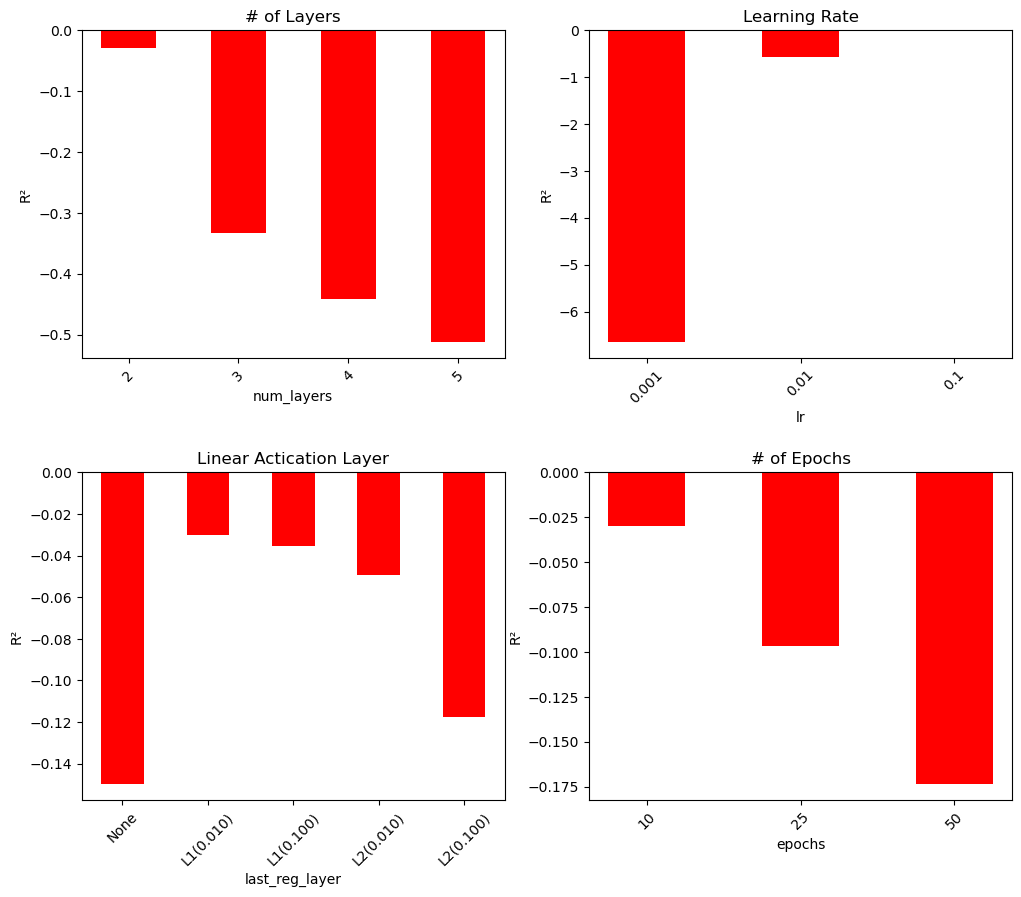

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
bar_width = 0.5
names = ['# of Layers', 'Learning Rate', 'Linear Actication Layer', '# of Epochs']

for idx, sweep in enumerate(sweeps):
    x_vals = sweep[param_names[idx]]
    y_vals = sweep['r2_valid']
    positions = np.arange(len(x_vals))
    
    axes[idx].bar(positions, y_vals, width=bar_width, color='red')
    axes[idx].set_xticks(positions)
    axes[idx].set_xticklabels(x_vals, rotation=45)
    axes[idx].set_title(names[idx])
    axes[idx].set_ylabel("R²")
    axes[idx].set_xlabel(param_names[idx])

plt.subplots_adjust(hspace=0.35)



---

<h1><center>Random Forest

---

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time

In [44]:
#RF_1, RF_2, RF_3: increasing n_estimators (50, 100, 200)
#RF_4: regularized trees (shallower trees, min leaf = 5)
#RF_5: strongly regularized trees (more trees, deeper but min leaf = 10)

rf_configs = {
    'RF_1 (50 trees)': RandomForestRegressor(
        n_estimators=50,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=rand_seed,
        n_jobs=-1
    ),
    'RF_2 (100 trees)': RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=rand_seed,
        n_jobs=-1
    ),
    'RF_3 (200 trees)': RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=rand_seed,
        n_jobs=-1
    ),
    'RF_4 (100 trees, depth=10, leaf=5)': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=5,
        random_state=rand_seed,
        n_jobs=-1
    ),
    'RF_5 (300 trees, depth=15, leaf=10)': RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=2,
        min_samples_leaf=10,
        random_state=rand_seed,
        n_jobs=-1
    ),
}

In [45]:
rf_results = []
rf_fitted_models = {}

for name, model in rf_configs.items():
    #Training the model and recording training time
    start = time.time()
    model.fit(Xtrain_norm_df, ytrain_df.values.ravel())
    train_time = time.time() - start
    
    #Saving the fitted model
    rf_fitted_models[name] = model

    #Get predictions on train and validation sets
    ytrain_pred = model.predict(Xtrain_norm_df)
    yvalid_pred = model.predict(Xvalid_norm_df)

    #Computing performance metrics
    train_r2 = r2_score(ytrain_df, ytrain_pred)
    valid_r2 = r2_score(yvalid_df, yvalid_pred)
    valid_mae = mean_absolute_error(yvalid_df, yvalid_pred)
    valid_rmse = np.sqrt(mean_squared_error(yvalid_df, yvalid_pred))

    #Storing the results
    rf_results.append({
        'Model': name,
        'n_estimators': model.n_estimators,
        'max_depth': model.max_depth,
        'min_samples_leaf': model.min_samples_leaf,
        'Train R²': train_r2,
        'Valid R²': valid_r2,
        'Valid MAE': valid_mae,
        'Valid RMSE': valid_rmse,
        'Train Time (s)': train_time
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.head()

,Model,n_estimators,max_depth,min_samples_leaf,Train R²,Valid R²,Valid MAE,Valid RMSE,Train Time (s)
0,RF_1 (50 trees),50,NaN,1,0.847538,0.025333,22.680006,27.207897,0.112154
1,RF_2 (100 trees),100,NaN,1,0.855457,0.045161,22.617864,26.929724,0.175575
2,RF_3 (200 trees),200,NaN,1,0.858645,0.035131,22.760025,27.070793,0.485284
3,"RF_4 (100 trees, depth=10, leaf=5)",100,10.0,5,0.514347,0.035200,22.699268,27.069827,0.170217
4,"RF_5 (300 trees, depth=15, leaf=10)",300,15.0,10,0.368855,0.017811,22.894023,27.312680,0.449921


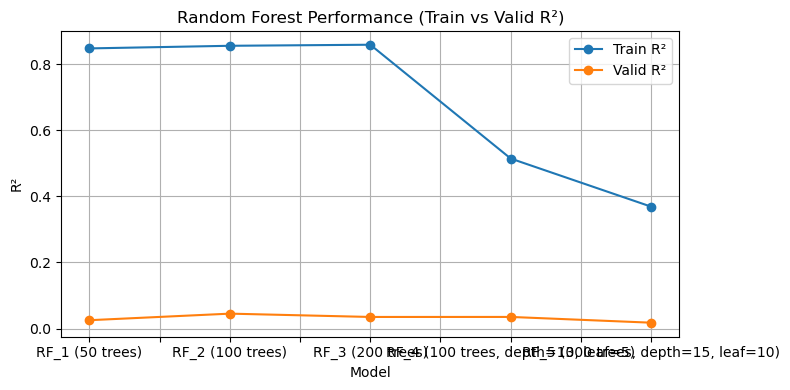

In [46]:
#Plotting train_r2, valid_r2
rf_results_df.plot(
    x='Model',
    y=['Train R²', 'Valid R²'],
    marker='o',
    figsize=(8, 4),
    title='Random Forest Performance (Train vs Valid R²)'
)
plt.ylabel("R²")
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
#Selecting model with highest validation R²
best_rf_row = rf_results_df.loc[rf_results_df['Valid R²'].idxmax()]
best_rf_name = best_rf_row['Model']
best_rf = rf_fitted_models[best_rf_name]

print("Best RF model (based on validation R²):")
display(best_rf_row[['Model', 'n_estimators', 'max_depth', 'min_samples_leaf', 
                     'Train R²', 'Valid R²', 'Valid MAE', 'Valid RMSE', 'Train Time (s)']])

#Evaluating the best RF model on the test set
ytest_pred = best_rf.predict(Xtest_norm_df)
test_r2 = r2_score(ytest_df, ytest_pred)
test_mae = mean_absolute_error(ytest_df, ytest_pred)
test_rmse = np.sqrt(mean_squared_error(ytest_df, ytest_pred))

print("\nTest performance of best RF model:")
print(f"Test R²:   {test_r2:.3f}")
print(f"Test MAE:  {test_mae:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

Best RF model (based on validation R²):


Model               RF_2 (100 trees)
n_estimators                     100
max_depth                        NaN
min_samples_leaf                   1
Train R²                    0.855457
Valid R²                    0.045161
Valid MAE                  22.617864
Valid RMSE                 26.929724
Train Time (s)              0.175575
Name: 1, dtype: object


Test performance of best RF model:
Test R²:   -0.053
Test MAE:  26.872
Test RMSE: 31.054


In [48]:
#Computing feature importances for all engineered features
importances = best_rf.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names_x,
    'Importance': importances
}).sort_values('Importance', ascending=False)

feat_imp_df

,Feature,Importance
5,num__Charging Cycles,0.169188
1,num__Voltage (V),0.159962
2,num__Current (A),0.154385
4,num__Ambient Temp (°C),0.152595
0,num__SOC (%),0.143913
3,num__Battery Temp (°C),0.135620
9,cat__EV Model_Model B,0.019597
6,cat__Charging Mode_Normal,0.017265
8,cat__Battery Type_LiFePO4,0.015947
7,cat__Charging Mode_Slow,0.015801


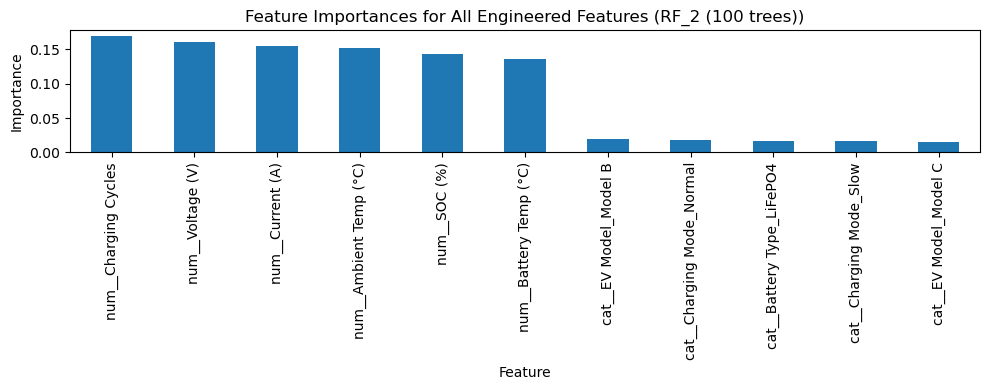

In [49]:
#Plotting feature importances for ALL engineered features
feat_imp_df.plot(
    x='Feature',
    y='Importance',
    kind='bar',
    figsize=(10, 4),
    legend=False
)
plt.ylabel("Importance")
plt.title(f"Feature Importances for All Engineered Features ({best_rf_name})")
plt.tight_layout()
plt.show()

---

<h1><center>Best Model and Evaluation with the Test Data

---

In [50]:
# The best model from each family is stored in results
# Finding the best R2 score in there will give the best model


In [51]:
tot_time = time.time() - tot_start
print(tot_time)

900.6330242156982
